# BACVP CTD Up Profiles Example
![fig](../figures/bacvp_ctd_up_profiles.jpg "fig")

In [1]:
from datetime import datetime, timezone, timedelta
import gsw
import matplotlib.pyplot as plt
import pandas as pd

from ONCToolbox import ONCToolbox, nan_onc_flags, remove_onc_flags
from ONCToolbox.utils.profilers import identify_profiles

In [2]:
onct = ONCToolbox()

In [3]:
# date_from = datetime(2025,6,14,22,0,0,0)
# date_to = datetime(2025,6,15,23,59,59,999999)

date_to = datetime.now(timezone.utc)
date_from = date_to - timedelta(days = 7)

In [4]:
cl = onct.get_fullres_data(location_code = 'BACVP',
                           device_category_code = 'DC90',
                           property_code = 'length',
                           date_from = date_from, 
                           date_to = date_to, 
                           out_as = 'xarray',
                           add_metadata = True)
cable_length = cl.cable_length
cable_length = cable_length.dropna(dim = 'time')

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 23 pages in total.
Estimated approx. 34 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (400000 samples) Downloading page 5...
   (500000 samples) Downloading page 6...
   (600000 samples) Downloading page 7...
   (700000 samples) Downloading page 8...
   (800000 samples) Downloading page 9...
   (900000 samples) Downloading page 10...
   (1000000 samples) Downloading page 11...
   (1100000 samples) Downloading page 12...
   (1200000 samples) Downloading page 13...
   (1300000 samples) Downloading page 14...
   (1400000 samples) Downloading page 15...
   (1500000 samples) Downloading page 16...
   (1600000 samples) Downloading page 17...
   (1700000 samples) Downloading page 18...
   (1800000 samples) Downloading page 19...
   (1900000 samples) Downloading 

## Identify Up Profiles

In [5]:
ups = identify_profiles(cable_length, profile_direction='up', max_allowed_std=0.05)

ups = [up for up in ups if (up['date_to'] - up['date_from']).total_seconds() > 60*3] # Keep only profiles longer than 3 minutes.

In [6]:
ctd = onct.get_fullres_data(location_code = 'BACVP',
                            device_category_code = 'CTD',
                           date_from = date_from, 
                           date_to = date_to, 
                           out_as = 'xarray',
                           add_metadata = True)
ctd = nan_onc_flags(ctd)
ctd = remove_onc_flags(ctd)

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 24 pages in total.
Estimated approx. 7 minutes to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (400000 samples) Downloading page 5...
   (500000 samples) Downloading page 6...
   (600000 samples) Downloading page 7...
   (700000 samples) Downloading page 8...
   (800000 samples) Downloading page 9...
   (900000 samples) Downloading page 10...
   (1000000 samples) Downloading page 11...
   (1100000 samples) Downloading page 12...
   (1200000 samples) Downloading page 13...
   (1300000 samples) Downloading page 14...
   (1400000 samples) Downloading page 15...
   (1500000 samples) Downloading page 16...
   (1600000 samples) Downloading page 17...
   (1700000 samples) Downloading page 18...
   (1800000 samples) Downloading page 19...
   (1900000 samples) Downloading p

In [7]:
profiles = []
for up in ups:
    ctd_pro = ctd.sel(time = slice(up['date_from'],up['date_to']))
    
    ctd_pro = ctd_pro.sortby('time')
    ctd_pro = ctd_pro.dropna(dim = 'time', how = 'all')
    ctd_pro = ctd_pro.assign_coords({'profile_id': [pd.to_datetime(ctd_pro.time.min().values).strftime('%Y%m%dT%H%M%SZ')]})
    ctd_pro = ctd_pro.rolling({'time': 5}, center=True, min_periods=1).median(skipna = True) # Apply a rolling median to smooth the data.

    # Convert cond from S/m to mS/cm for GSW.
    ctd_pro['conductivity'] = ctd_pro['conductivity'] * 10
    ctd_pro['conductivity'].attrs['uom'] = 'mS/cm'
    ctd_pro['conductivity'].attrs['unitOfMeasure'] = 'mS/cm'
    
    ctd_pro['practical_salinity'] = gsw.SP_from_C(ctd_pro.conductivity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['absolute_salinity'] = gsw.SA_from_SP(ctd_pro.practical_salinity, ctd_pro.temperature,
                                                            lon =  ctd_pro.attrs['lon'], lat =  ctd_pro.attrs['lat'])
    ctd_pro['conservative_temperature'] = gsw.CT_from_t(ctd_pro.absolute_salinity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['density'] = gsw.density.rho(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature, ctd_pro.pressure)
    ctd_pro['potential_density'] = gsw.sigma0(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature)
    ctd_pro['depth'] = gsw.z_from_p(ctd_pro.pressure, ctd_pro.attrs['lat'])*-1
    
    profiles.append(ctd_pro)

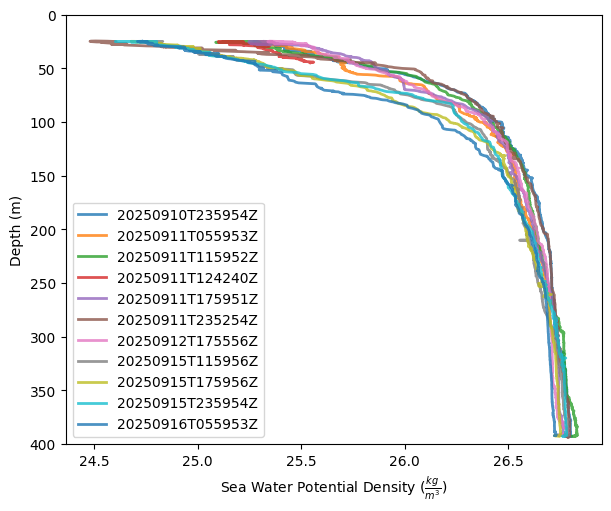

In [10]:
fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)

for i in range(len(profiles)):
    pro = profiles[i]
    ax.plot(pro.potential_density, pro.depth, alpha = 0.8, label = pro.profile_id.values, linewidth = 2)
    
ax.legend(loc = 'lower left')

ax.set_ylim(0,400)

ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel(r'Sea Water Potential Density ($\frac{kg}{m^3}$)')
plt.savefig('../figures/bacvp_ctd_up_profiles.jpg')